In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import SplineTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

from tensorflow import compat
compat.v1.logging.set_verbosity(compat.v1.logging.ERROR)

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE?'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}


In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

In [6]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)

In [7]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

In [8]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
# model.add(LSTM(units=64, activation="relu")),
model.add(Bidirectional(LSTM(128, activation="relu")))
# model.add(Dense(units=64, activation="relu")),
# model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)


KeyboardInterrupt



In [9]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
# model.add(LSTM(units=64, activation="relu")),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 3ms/step
Scores obtidos:
RMSE: 23451.509343041093
MAE: 13035.839076114478
MAPE: 0.15322315601094444
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 36259.80116603583
MAE: 22978.39315814394
MAPE: 0.2461412572154938


In [13]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [16]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))
    
    plt.title("Distribuição do erro")
    plt.xlabel("Categorias")
    plt.ylabel("quantidade")

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    g.set(ylabel="quantidade")
    total = error.shape[0]
    
    for p in g.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.annotate(percentage, (x-0.4, y+1),ha='left')
    
    plt.show()
    
    return error

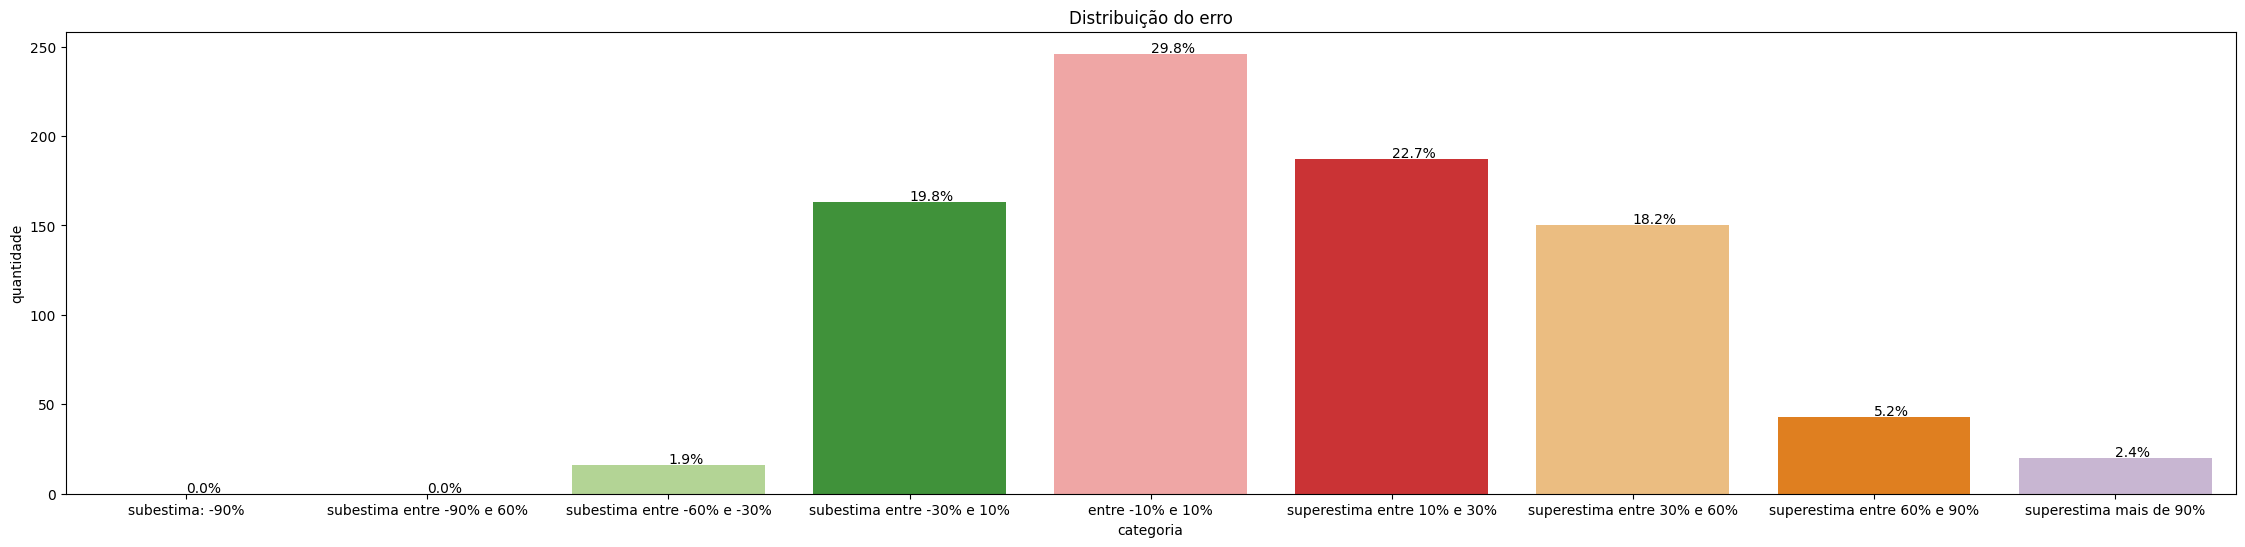

,erro,categoria
0,-0.072454,entre -10% e 10%
1,-0.029770,entre -10% e 10%
2,0.214377,superestima entre 10% e 30%
3,0.277508,superestima entre 10% e 30%
4,-0.063973,entre -10% e 10%
...,...,...
820,-0.002613,entre -10% e 10%
821,-0.013453,entre -10% e 10%
822,-0.003588,entre -10% e 10%
823,0.201695,superestima entre 10% e 30%


In [17]:
show_delta(np.array(y_test), y_pred.flatten())

In [20]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 39189.79914293231
MAE: 21903.84882790919
MAPE: 0.20538012979752607
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 45534.61276334883
MAE: 26907.49469223485
MAPE: 0.2112641809382626


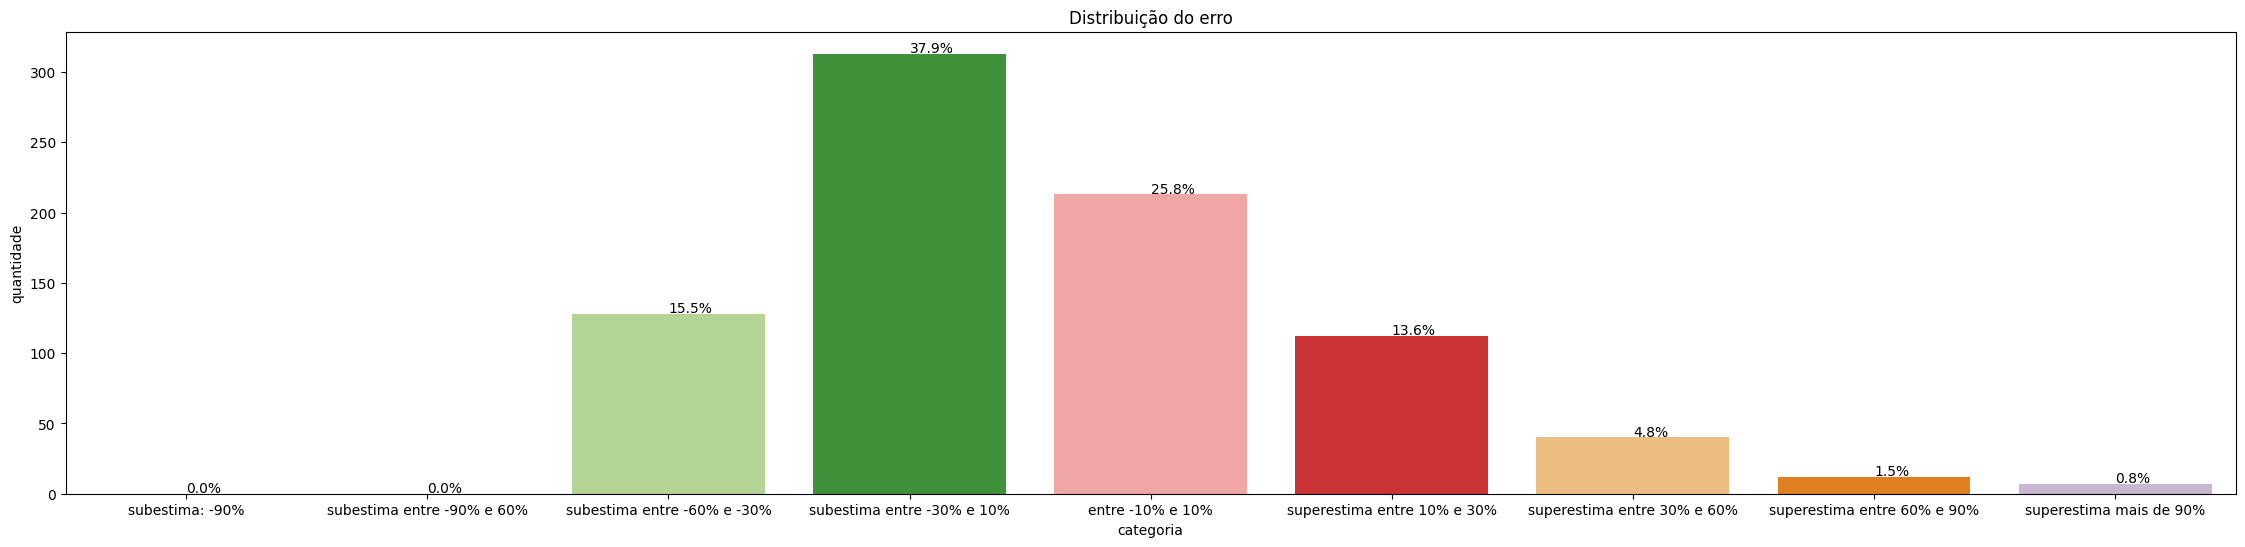

,erro,categoria
0,-0.204773,subestima entre -30% e 10%
1,-0.349134,subestima entre -60% e -30%
2,-0.059570,entre -10% e 10%
3,0.114210,superestima entre 10% e 30%
4,-0.256886,subestima entre -30% e 10%
...,...,...
820,-0.188827,subestima entre -30% e 10%
821,-0.106184,subestima entre -30% e 10%
822,-0.147786,subestima entre -30% e 10%
823,0.056881,entre -10% e 10%


In [21]:
show_delta(np.array(y_test), y_pred.flatten())

In [22]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 28237.00836594533
MAE: 14689.360896249365
MAPE: 0.1943422192421757
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 39530.29858038262
MAE: 25327.83852568655
MAPE: 0.3636018201243031


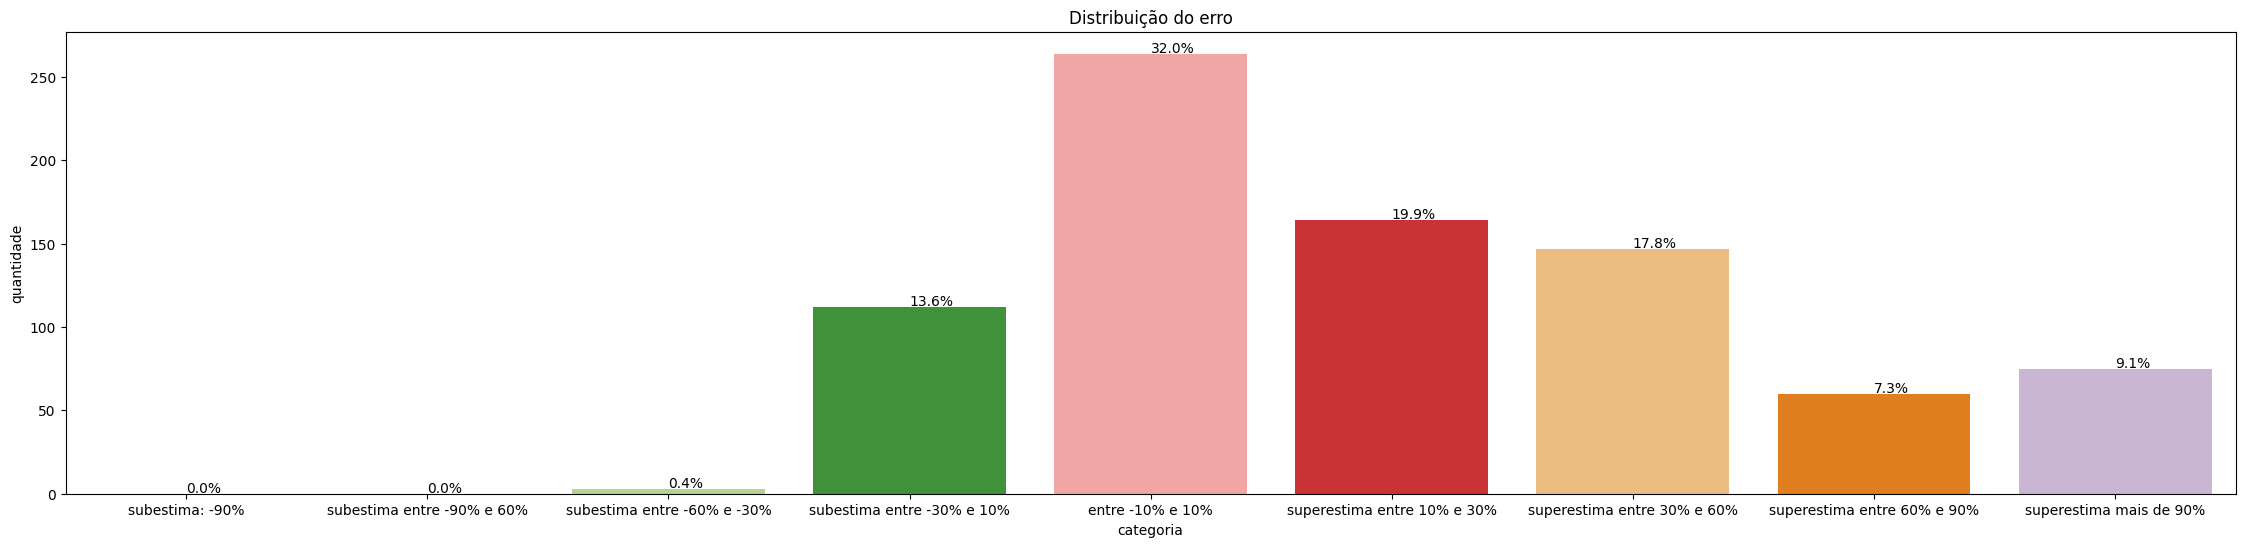

,erro,categoria
0,-0.063724,entre -10% e 10%
1,-0.082220,entre -10% e 10%
2,0.197914,superestima entre 10% e 30%
3,0.256220,superestima entre 10% e 30%
4,-0.129251,subestima entre -30% e 10%
...,...,...
820,0.044786,entre -10% e 10%
821,0.054666,entre -10% e 10%
822,0.208013,superestima entre 10% e 30%
823,0.245680,superestima entre 10% e 30%


In [23]:
show_delta(np.array(y_test), y_pred.flatten())

In [24]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 7ms/step
Scores obtidos:
RMSE: 29742.657522986483
MAE: 16274.715610296671
MAPE: 0.21453926654527997
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 38725.56791149714
MAE: 23669.1384522964
MAPE: 0.2980344406696295


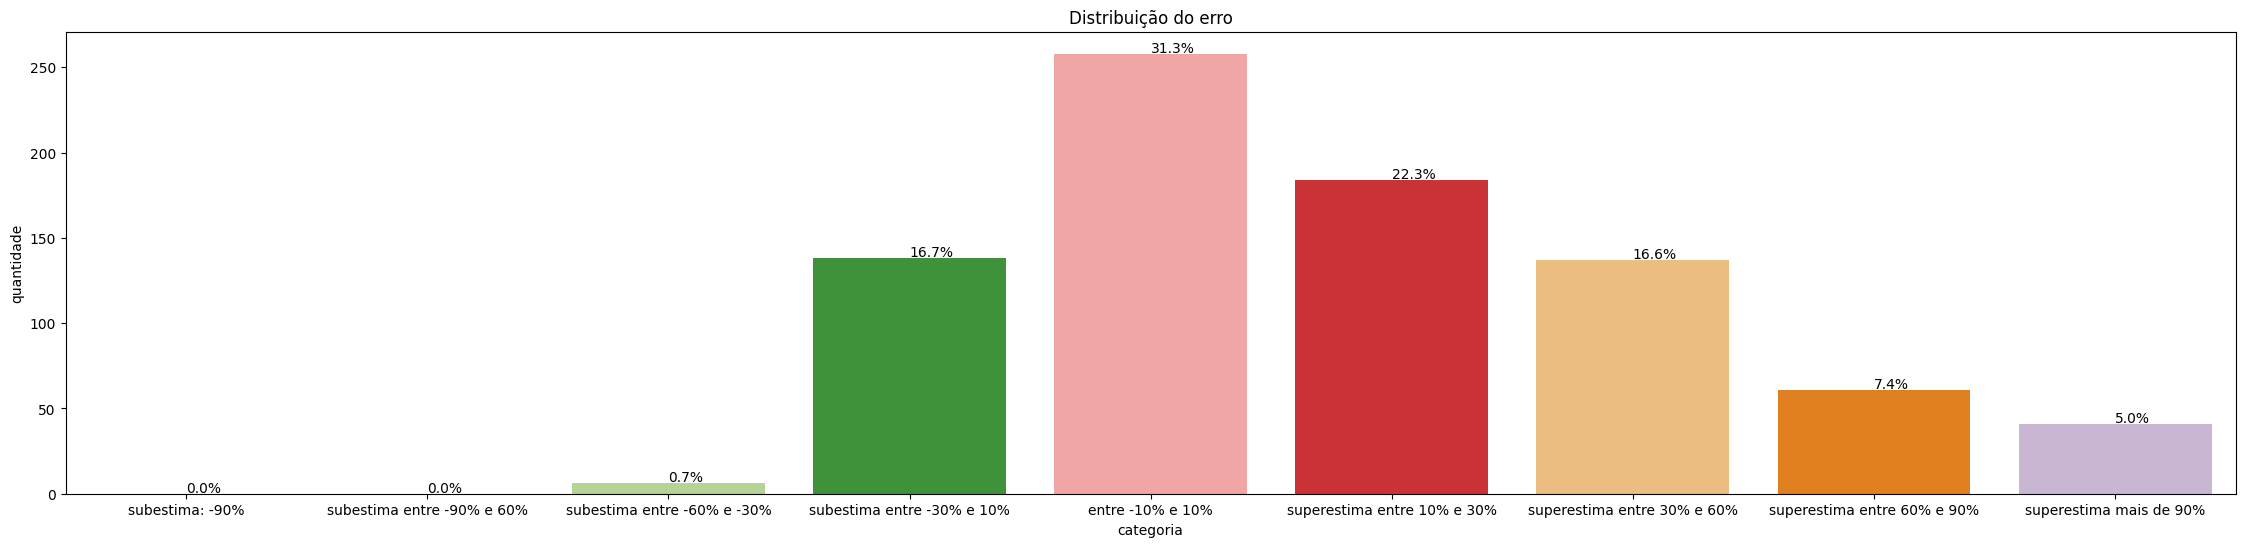

In [25]:
error=show_delta(np.array(y_test), y_pred.flatten())

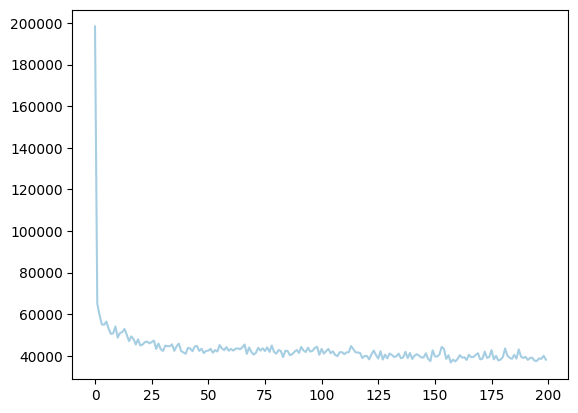

In [26]:
plt.plot(history.history['RMSE'])

In [27]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(128, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 8ms/step
Scores obtidos:
RMSE: 21272.69895615223
MAE: 12044.488170464943
MAPE: 0.1351305732518473
26/26 [==============================] - 0s 8ms/step
Scores obtidos:
RMSE: 34407.91072394859
MAE: 21460.923043323863
MAPE: 0.2337302919430505


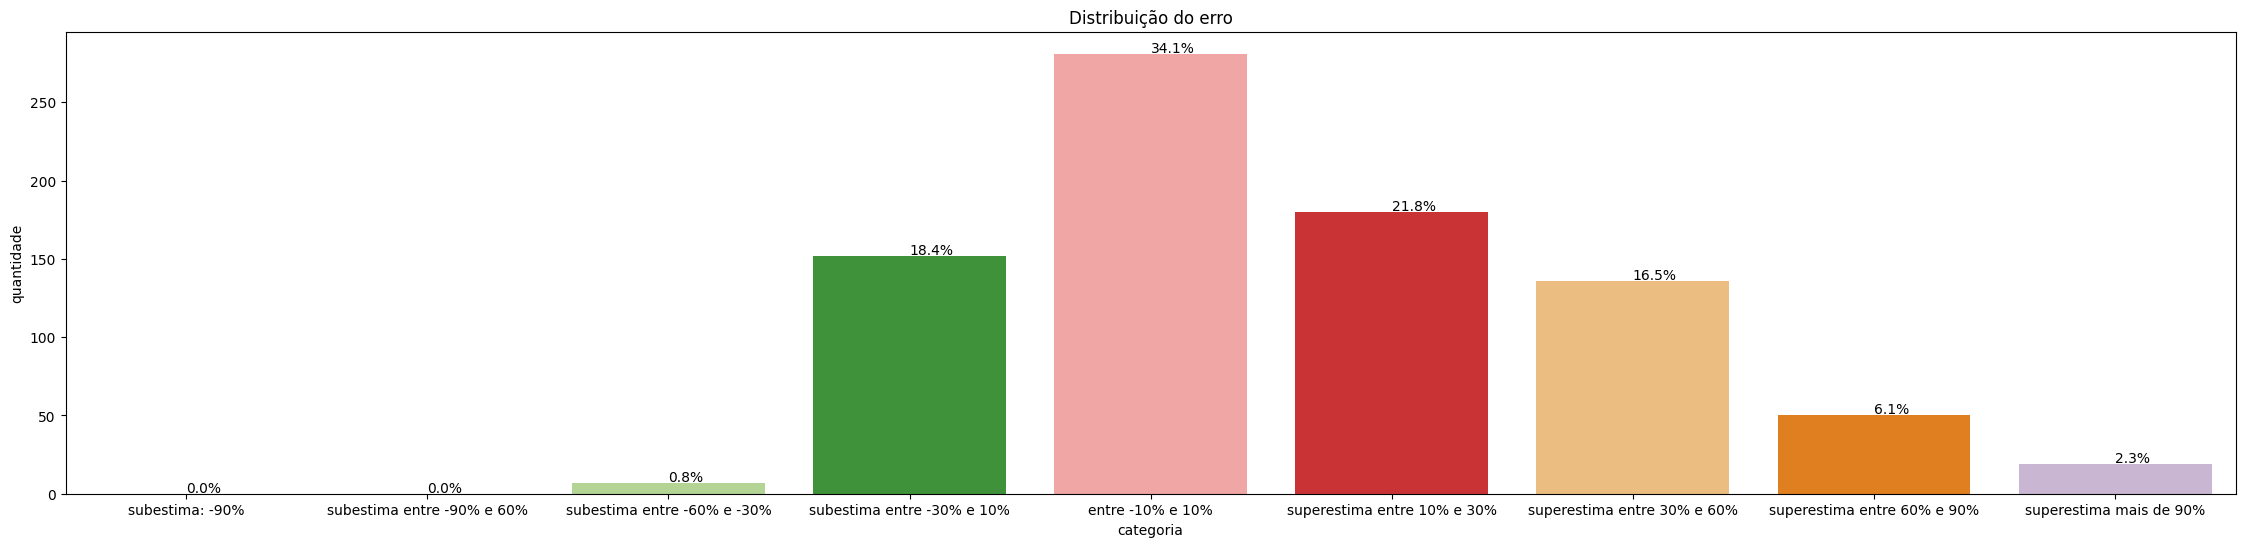

In [28]:
error=show_delta(np.array(y_test), y_pred.flatten())

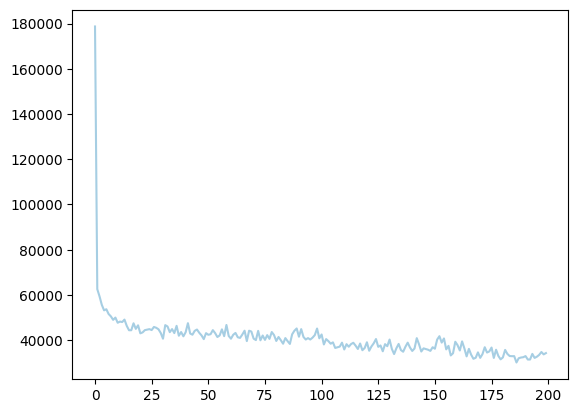

In [29]:
plt.plot(history.history['RMSE'])

In [30]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 9s 19ms/step
Scores obtidos:
RMSE: 24048.223204676935
MAE: 14749.073762363669
MAPE: 0.12619856084050485
26/26 [==============================] - 1s 26ms/step
Scores obtidos:
RMSE: 34513.9160804397
MAE: 19845.027296401517
MAPE: 0.18921370143594032


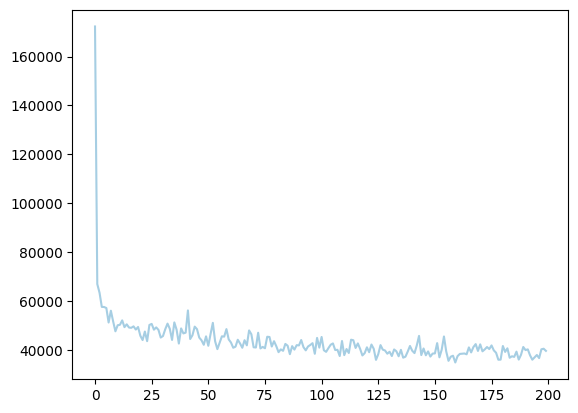

In [31]:
plt.plot(history.history['RMSE'])

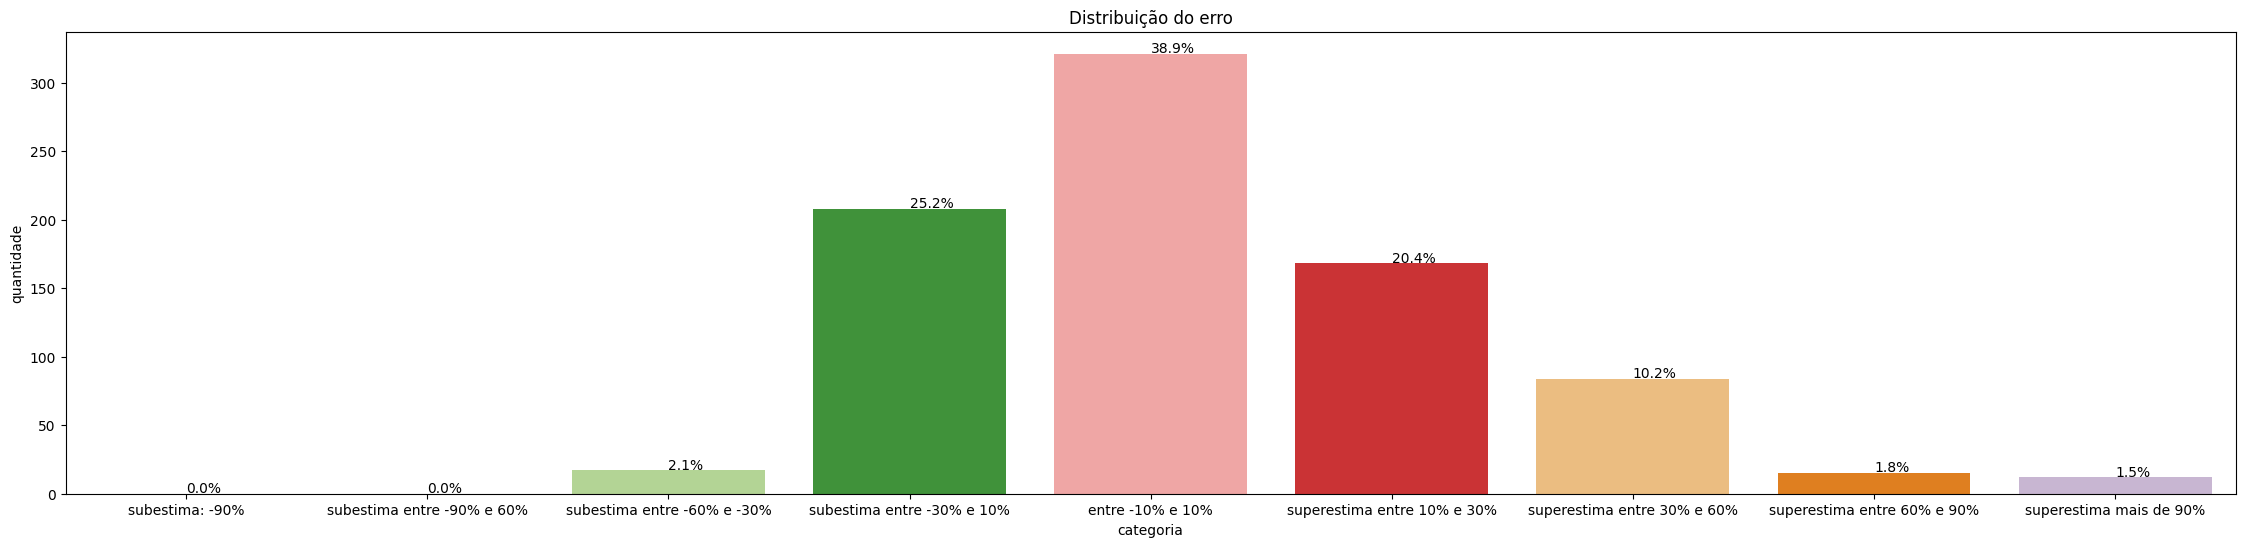

In [32]:
error=show_delta(np.array(y_test), y_pred.flatten())

In [9]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 5s 17ms/step
Scores obtidos:
RMSE: 24048.223204676935
MAE: 14749.073762363669
MAPE: 0.12619856084050485
26/26 [==============================] - 1s 20ms/step
Scores obtidos:
RMSE: 34513.9160804397
MAE: 19845.027296401517
MAPE: 0.18921370143594032


In [37]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 25767.608768412305
MAE: 14203.996919978228
MAPE: 0.18203195368766123
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 42512.60893999862
MAE: 24818.820765269887
MAPE: 0.27658035354549665


In [38]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=300, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 23875.001083630985
MAE: 13125.703927885064
MAPE: 0.14553643034556585
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 45713.475298012825
MAE: 24573.052377485794
MAPE: 0.23796859728913874


In [39]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True,  activation="relu")))
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 6ms/step
Scores obtidos:
RMSE: 28599.30847663491
MAE: 15696.763226014005
MAPE: 0.194888806882544
26/26 [==============================] - 0s 8ms/step
Scores obtidos:
RMSE: 34931.746754348955
MAE: 22677.321832386362
MAPE: 0.3464867682752102


In [42]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True,  activation="relu")))
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 4s 12ms/step
Scores obtidos:
RMSE: 21961.760732961066
MAE: 12245.38739310678
MAPE: 0.16178789580267117
26/26 [==============================] - 0s 15ms/step
Scores obtidos:
RMSE: 38465.13263980245
MAE: 24515.567246685605
MAPE: 0.3547499401209095


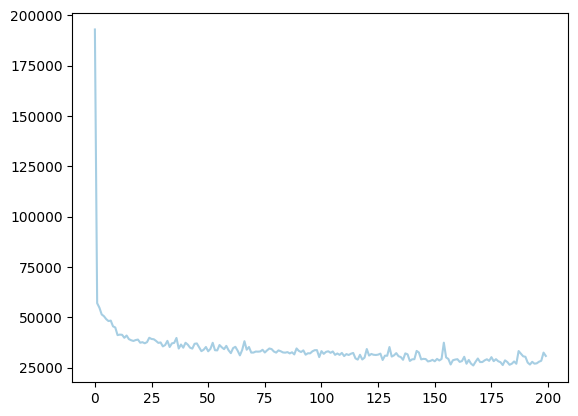

In [43]:
plt.plot(history.history['RMSE'])

In [45]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, activation="relu")),
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(64, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 6s 25ms/step
Scores obtidos:
RMSE: 28828.664428655517
MAE: 14431.473132305748
MAPE: 0.15174503564112343
26/26 [==============================] - 1s 27ms/step
Scores obtidos:
RMSE: 66040.91993758295
MAE: 40961.70714666193
MAPE: 0.45415413830021906


In [46]:
x

,pib_pc,pib_pmc,pib_pcpt,pib_cc,populacao,incc,ipca,igp,selic,idh_l,...,estados_PR,estados_RJ,estados_RN,estados_RO,estados_RR,estados_RS,estados_SC,estados_SE,estados_SP,estados_TO
0,4.342234e+05,2.285692e+05,0.739806,5.065002e+05,586942.0,1.70,12.53,2.70,0.082293,0.694,...,0,0,0,0,0,0,0,0,0,0
204,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.70,12.53,2.70,0.082293,0.647,...,0,0,0,0,0,0,0,0,0,0
408,2.883869e+06,1.518029e+06,0.973688,2.401570e+06,2961801.0,1.70,12.53,2.70,0.082293,0.692,...,0,0,0,0,0,0,0,0,0,0
612,4.708095e+05,2.478276e+05,0.911519,3.136418e+05,516511.0,1.70,12.53,2.70,0.082293,0.711,...,0,0,0,0,0,0,0,0,0,0
816,7.990762e+06,4.206227e+06,0.599762,7.050330e+06,13323212.0,1.70,12.53,2.70,0.082293,0.680,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,1.958375e+07,3.304449e+07,1.729000,8.974276e+06,11329605.0,0.04,3.12,0.85,0.018985,0.850,...,0,0,0,0,0,1,0,0,0,0
4895,1.224351e+07,2.065900e+07,1.735954,7.026914e+06,7075494.0,0.04,3.12,0.85,0.018985,0.870,...,0,0,0,0,0,0,1,0,0,0
5099,1.841252e+06,3.106822e+06,0.808166,1.091268e+06,2278308.0,0.04,3.12,0.85,0.018985,0.800,...,0,0,0,0,0,0,0,1,0,0
5303,9.150468e+07,1.543997e+08,2.009372,4.080742e+07,45538936.0,0.04,3.12,0.85,0.018985,0.850,...,0,0,0,0,0,0,0,0,1,0
